# Self-Driving Car Engineer Nanodegree

## Project : Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
%matplotlib inline


## Camera Calibration and Distortion Measurement
Compute the camera calibration matrix and distortion coefficients using chessboard images

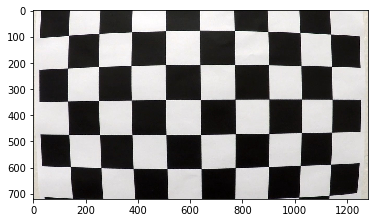

In [2]:
#Read all the calibration images and show one of them
images = glob.glob('camera_cal/calibration*.jpg')
img_show = mpimg.imread(images[0])
plt.imshow(img_show)


In [3]:
#Arrays to store objects and images points
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in images

#prepare object points
nx = 9
ny = 6

objp = np.zeros((nx*ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) #x, y coordinate

#find the chessboard corners
for fname in images:

    img_cali = mpimg.imread(fname)
    gray = cv2.cvtColor(img_cali, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # if found, add objps and imgps
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
         
        # Draw and display the corners
        img_cali = cv2.drawChessboardCorners(img_cali, (nx,ny), corners, ret)
        cv2.imshow('img',img_cali)
        cv2.waitKey(500)

cv2.destroyAllWindows()


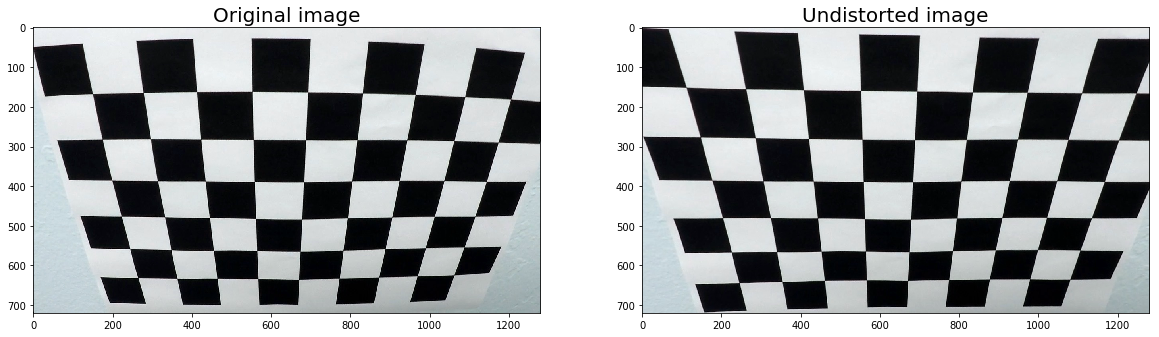

In [4]:
img_test = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img_test.shape[1], img_test.shape[0])

#do camera calibration given objps and imgps
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None) 
dst = cv2.undistort(img_test, mtx, dist, None, mtx)

#save the camera calibration for later use
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump( dist_pickle, open( 'camera_calibration/wide_dist_pickle.p', 'wb'))

#visiualize undistortion and save the undistorted and original images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_test)
ax1.set_title('Original image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted image', fontsize=20)
fig = plt.gcf()
fig.savefig('output_images/undistorted.png', dpi=100)


## Checkpoint1

Read in the saved camera calibration data from 'camera_calibration' file. 

In [2]:
#Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('camera_calibration/wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']


## Create thresholded binary images

The goal: use color transforms, gradients to get thresholded binary images

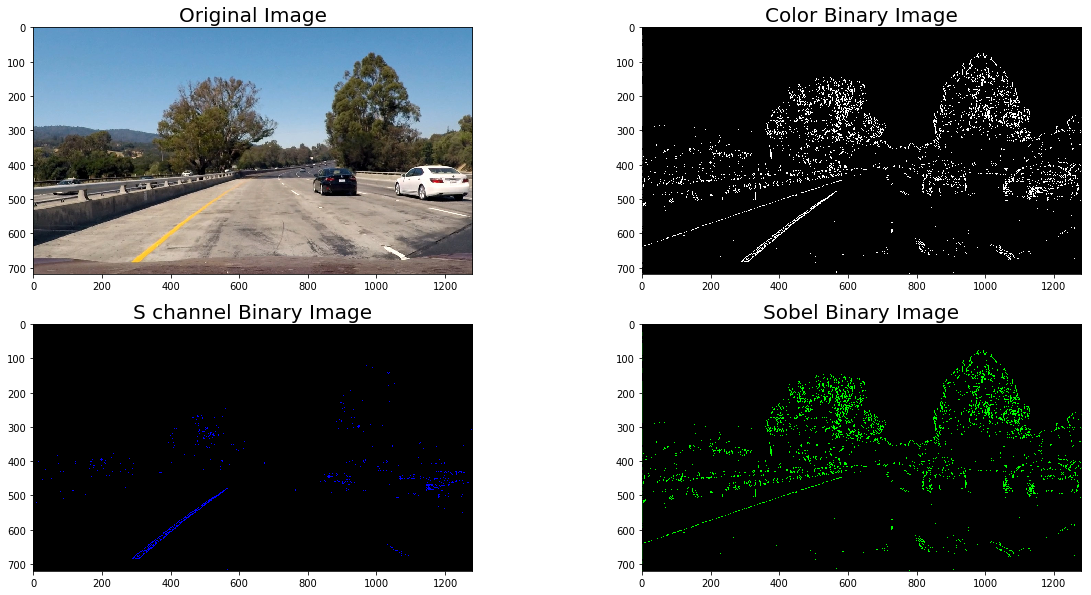

In [10]:
# read in an image
#img = mpimg.imread('test_images/straight_lines1.jpg')
img = mpimg.imread('test_images/test1.jpg')


def binary_image_pipeline(img, s_thresh=(180,255), sx_thresh=(30,100)):
    
    img = np.copy(img)
    #convert to HLS space and extract s and l channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #Sobelx
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobel = np.abs(sobelx)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel > sx_thresh[0]) & (scaled_sobel < sx_thresh[1])] = 1
    
    #threholded color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel < s_thresh[1])] = 1
    
    #combined 
    sobel_binary = np.dstack((np.zeros_like(binary_sobel), binary_sobel, np.zeros_like(s_binary))) * 255
    schan_binary = np.dstack((np.zeros_like(binary_sobel), np.zeros_like(binary_sobel), s_binary)) * 255
    color_binary = np.zeros_like(s_binary)
    color_binary[(binary_sobel == 1) | (s_binary == 1)] = 1
    
    return color_binary, schan_binary, sobel_binary

color_binary, schan_binary, sobel_binary = binary_image_pipeline(img)

f, axes = plt.subplots(2, 2, figsize=(20,10))
axes[0, 0].imshow(img)
axes[0, 0].set_title('Original Image', fontsize=20)
axes[0, 1].imshow(color_binary, cmap='gray')
axes[0, 1].set_title('Color Binary Image', fontsize=20)
axes[1, 0].imshow(schan_binary)
axes[1, 0].set_title('S channel Binary Image', fontsize=20)
axes[1, 1].imshow(sobel_binary)
axes[1, 1].set_title('Sobel Binary Image', fontsize=20)
fig = plt.gcf()
fig.savefig('output_images/binary_images.png', dpi=100)

# Perspective Transform
Apply a perspective transform to 'bird-eye' view

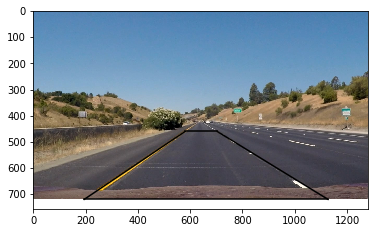

In [4]:
img = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])
plt.imshow(img)
#plt.plot([592,690], [450,450], 'k')
#plt.plot([200,1125], [720,720], 'k')
#plt.plot([200,592], [720,450], 'k')
#plt.plot([690,1125], [450,720], 'k')
plt.plot([581,703], [460,460], 'k')
plt.plot([195,1127], [720,720], 'k')
plt.plot([195,581], [720,460], 'k')
plt.plot([703,1127], [460,720], 'k')
fig = plt.gcf()
fig.savefig('output_images/Perspective Transform1.png', dpi=100)

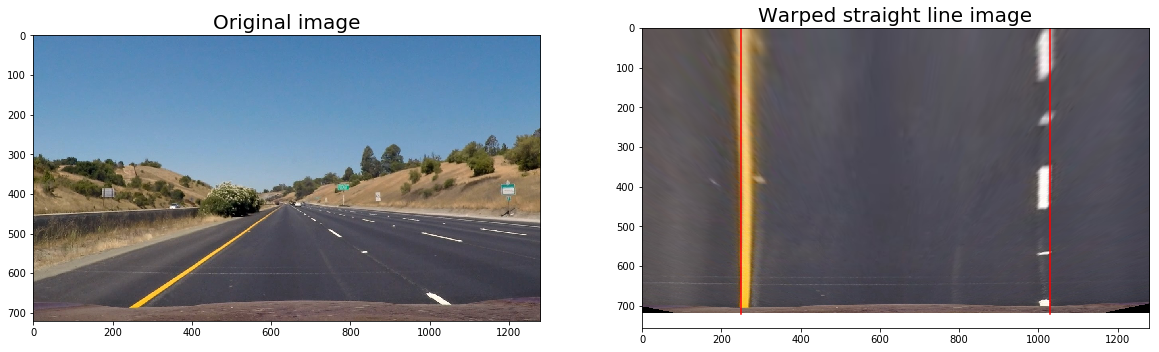

In [5]:
#Calculate the perspective transform matrix
#offset for dst
offset = 250
#Four source coordinates
src = np.float32(
    [[581, 460],
     [703, 460],
     [195, 720],
     [1127, 720]])

#Four desired coordinates
dst = np.float32(
    [[offset, 0],
     [img_size[0] - offset, 0],
     [offset, img_size[1]],
     [img_size[0] - offset, img_size[1]]])

#Calculate the perspective matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

dist_pickle_1 = {}
dist_pickle['M'] = M
dist_pickle['Minv'] = Minv
pickle.dump( dist_pickle, open( 'camera_calibration/wide_dist_pickle_1.p', 'wb'))
#Warp the image 
warped = cv2.warpPerspective(img, M, img_size)

#visiualize perspective transform and save the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original image', fontsize=20)
ax2.imshow(warped)
ax2.plot([offset, offset], [0, 720],'r')
ax2.plot([img_size[0] - offset, img_size[0] - offset], [0, 720],'r')
ax2.set_title('Warped straight line image', fontsize=20)
fig = plt.gcf()
fig.savefig('output_images/Perspective Transform2.png', dpi=100)

# Detect the Lane line boundries

In [6]:
#Read in the saved Perspective transform matrix
dist_pickle_1 = pickle.load(open('camera_calibration/wide_dist_pickle_1.p', 'rb'))
M = dist_pickle_1['M']
Minv = dist_pickle_1['Minv']

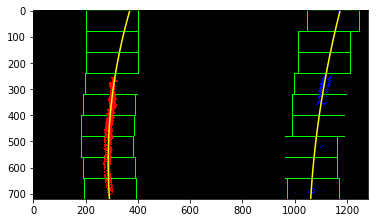

In [11]:
#Get one of the warped binary image
binary_warped = cv2.warpPerspective(color_binary, M, img_size)

def find_lane_pixels(binary_warped):
    
    #find the line in the first image using slide windows
    
    #find the peak of the histogram of bottom half of the image(the position of the first window)
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #hyperparameters
    nwindows = 9  #number of the sliding windows
    margin = 100  #the width of the window margin 
    minpix = 50  #the minimum number of pixels to recenter the window
    
    window_height = np.int(binary_warped.shape[0] // nwindows) 
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #the position of the current window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    #the pixels indices of the left line points and right line points
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        #draw the windows on the visualizalied image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                     (win_xleft_high, win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                     (win_xright_high, win_y_high), (0,255,0), 2)
        
        #identify the nonzero pixels in the rectangles 
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)
                         & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high)
                          & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #recenter the window if the nonzero pixels in the box is more than minpix
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img



def fit_polynomial(binary_warped):
    #find the lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    #fit a 2nd order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
             
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, left_fitx, right_fitx, ploty

def get_polynomial(binary_warped, ym_per_pix, xm_per_pix):
    #find the lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    #fit a 2nd order polynomial
    left_fit = np.polyfit(ym_per_pix*lefty, xm_per_pix*leftx, 2)
    right_fit = np.polyfit(ym_per_pix*righty, xm_per_pix*rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    return ploty, left_fit, right_fit

out_img, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)

plt.imshow(out_img)
fig = plt.gcf()
fig.savefig('output_images/detect_lane_line.png', dpi=100)

# Calculate the radius of curvature and the vehicle position 

In [12]:
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty, left_fit_cr, right_fit_cr = get_polynomial(binary_warped ,ym_per_pix, xm_per_pix)
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.abs(2*left_fit_cr[0])   ## Implement the calculation of the left line here
    right_curverad =  ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.abs(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

def measure_vehicle_position():
    '''
    
    Calculate the distance between the centers of the car and the lane line
    '''
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    pixel_vihecle_position = img.shape[1]//2 
    pixel_lane_center = (right_fitx[-1] - left_fitx[-1])/2
    vehicle_position = (pixel_vihecle_position - pixel_lane_center)*xm_per_pix
    return vehicle_position
    
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()
pos_meters = measure_vehicle_position()
print(left_curverad, 'm', right_curverad, 'm', pos_meters, 'm')

662.6048684218821 m 1225.4274349504344 m 1.349340884891506 m


# Warp the lane line back to the original image

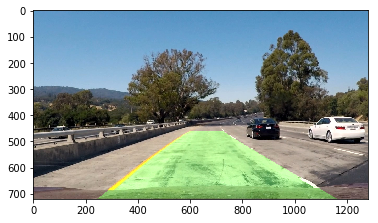

In [13]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
#color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
color_warp = warp_zero

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)

fig = plt.gcf()
fig.savefig('output_images/warp_back.png', dpi=100)

## checkpoint 2

In [66]:
#Read in the saved ......
dist_pickle = pickle.load(open('camera_calibration/wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
dist_pickle_1 = pickle.load(open('camera_calibration/wide_dist_pickle_1.p', 'rb'))
M = dist_pickle_1['M']
Minv = dist_pickle_1['Minv']


In [79]:
## Functions for lane line finding

        
def binary_image_pipeline(img, s_thresh=(180,255), sx_thresh=(30,100)):
    
    img = np.copy(img)
    #convert to HLS space and extract s and l channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #Sobelx
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobel = np.abs(sobelx)
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel > sx_thresh[0]) & (scaled_sobel < sx_thresh[1])] = 1
    
    #threholded color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel < s_thresh[1])] = 1
    
    #combined 
    sobel_binary = np.dstack((np.zeros_like(binary_sobel), binary_sobel, np.zeros_like(s_binary))) * 255
    schan_binary = np.dstack((np.zeros_like(binary_sobel), np.zeros_like(binary_sobel), s_binary)) * 255
    color_binary = np.zeros_like(s_binary)
    color_binary[(binary_sobel == 1) | (s_binary == 1)] = 1
    
    return color_binary, schan_binary, sobel_binary

def find_lane_pixels(binary_warped):
    
    #find the peak of the histogram of bottom half of the image(the position of the first window)
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #hyperparameters
    nwindows = 9  #number of the sliding windows
    margin = 100  #the width of the window margin 
    minpix = 50  #the minimum number of pixels to recenter the window
    
    window_height = np.int(binary_warped.shape[0] // nwindows) 
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #the position of the current window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    #the pixels indices of the left line points and right line points
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        #draw the windows on the visualizalied image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                     (win_xleft_high, win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                     (win_xright_high, win_y_high), (0,255,0), 2)
        
        #identify the nonzero pixels in the rectangles 
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)
                         & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high)
                          & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #recenter the window if the nonzero pixels in the box is more than minpix
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    margin = 100

    # Grab activated pixels
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = (nonzerox <  left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin) & (nonzerox >  left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)
    right_lane_inds = (nonzerox <  right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin) & (nonzerox >  right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]



    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, is_detected_lines):
    #find the lane pixels
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    if is_detected_lines == False:
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    else:
        #recent_left_fit = np.array([ 4.54255520e-04, -6.21705881e-01,  4.54502077e+02])
        #recent_right_fit = np.array([ 5.15487159e-04, -7.50240484e-01,  1.32556754e+03])
        leftx, lefty, rightx, righty, out_img = search_around_poly(binary_warped, LEFT.recent_xfitted, RIGHT.recent_xfitted)
        #leftx, lefty, rightx, righty, out_img = search_around_poly(binary_warped, recent_left_fit, recent_right_fit)
        
    #fit a 2nd order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_m = np.polyfit(ym_per_pix*lefty, xm_per_pix*leftx, 2)
    right_fit_m = np.polyfit(ym_per_pix*righty, xm_per_pix*rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return out_img, left_fitx, right_fitx, ploty, left_fit_m, right_fit_m, left_fit, right_fit

def sanity_check(lines_distance_1, lines_distance_2):
    
    #hyperparameters
    error = np.max(np.abs(lines_distance_1 - lines_distance_2))
    delta = np.abs(error - LEFT.lastdelta)
    LEFT.lastdelta = error
    LEFT.delta.append(error)
    LEFT.delta2.append(delta)
    
    #check the gradient
    if (delta > 500):
        return False
    else:
        return True

def measure_curvature_real(left_fit_cr, right_fit_cr, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
#    ploty, left_fit_cr, right_fit_cr = get_polynomial(binary_warped ,ym_per_pix, xm_per_pix)
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.abs(2*left_fit_cr[0])   ## Implement the calculation of the left line here
    right_curverad =  ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.abs(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

def measure_vehicle_position(right_fitx, left_fitx, img):
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    pixel_vihecle_position = img.shape[1]//2 
    pixel_lane_center = (right_fitx[-1] + left_fitx[-1])/2
    pixel_lines_distance_1 = (right_fitx[-1] - left_fitx[-1])
    pixel_lines_distance_2 = (right_fitx[0] - left_fitx[0])
    vehicle_position = (pixel_vihecle_position - pixel_lane_center)*xm_per_pix
    lines_distance_1 = pixel_lines_distance_1*xm_per_pix
    lines_distance_2 = pixel_lines_distance_2*xm_per_pix
    return vehicle_position, lines_distance_1, lines_distance_2

def draw_line_back(ploty, left_fitx, right_fitx, img):
# Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
#color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = warp_zero

# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result
#plt.imshow(result)

def add_result(img, vehicle_position, left_curverad, right_curverad):
    font=cv2.FONT_HERSHEY_SIMPLEX
    img=cv2.putText(img,'left_curverad: {}m'.format(left_curverad),(0,40),font,1.5,(255,255,255),2)
    img=cv2.putText(img,'right_curverad: {}m'.format(right_curverad),(0,100),font,1.5,(255,255,255),2)
    img=cv2.putText(img,'vehicle_position: {}m'.format(vehicle_position),(0,160),font,1.5,(255,255,255),2)
    return img

# Pipeline for image processing

In [80]:
def img_find_lane_line(img):
    #image processing
    color_binary, _, _ = binary_image_pipeline(img)
    img_size = (img.shape[1], img.shape[0])
    binary_warped = cv2.warpPerspective(color_binary, M, img_size)
    

    is_detected_lines = False
    out_img, left_fitx, right_fitx, ploty, left_fit_m, right_fit_m, left_fit, right_fit = fit_polynomial(binary_warped, is_detected_lines)
    #calculation
    left_curverad, right_curverad = measure_curvature_real(left_fit_m, right_fit_m, ploty)
    vehicle_position,_ ,_ = measure_vehicle_position(right_fitx, left_fitx, img)
    #draw line
    result = draw_line_back(ploty, left_fitx, right_fitx, img)
    result = add_result(result, vehicle_position, left_curverad, right_curverad)
    return result


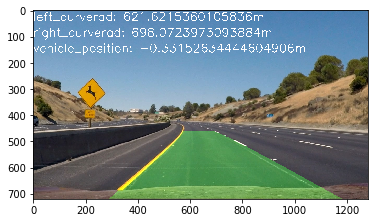

In [81]:
img = mpimg.imread('test_images/test2.jpg')

#result, left_fit, right_fit  = img_find_lane_line(img)
result = img_find_lane_line(img)

plt.imshow(result)


# Pipeline for Video Processing

In [83]:
from moviepy.editor import VideoFileClip

video_output = 'P4_video_final_challenge2.mp4'
clip = VideoFileClip('harder_challenge_video.mp4')
#clip = VideoFileClip('project_video.mp4')

class Line():
    def __init__(self):

        self.detected = False  
        self.recent_xfitted = [] 
        self.recent_xfits = []
        self.bestx = []
        self.delta = []
        self.delta2 = []
        self.lastdelta = 0

def video_find_lane_line(img):
    color_binary, _, _ = binary_image_pipeline(img)
    img_size = (img.shape[1], img.shape[0])
    binary_warped = cv2.warpPerspective(color_binary, M, img_size)
    
    #if (LEFT.detected) & (RIGHT.detected) == True:
    #    is_detected_lines = True
    #else:
    #    is_detected_lines = False
    is_detected_lines = False
        
    out_img, left_fitx, right_fitx, ploty, left_fit_m, right_fit_m, left_fit, right_fit = fit_polynomial(binary_warped, is_detected_lines)
    #out_img, left_fitx, right_fitx, ploty, left_fit_m, right_fit_m, left_fit, right_fit = fit_polynomial(binary_warped)
    left_curverad, right_curverad = measure_curvature_real(left_fit_m, right_fit_m, ploty)
    vehicle_position,_,_ = measure_vehicle_position(right_fitx, left_fitx, img)

    
    #LEFT.best_fit = np.mean(LEFT.recent_xfits, axis=0)
    
    #RIGHT.best_fit = np.mean(RIGHT.recent_xfits, axis=0)
    if LEFT.bestx == []:
        if left_fitx.all() != 0:
            LEFT.detected = True
        else:
            LEFT.detected = False
        
        if right_fitx.all() != 0:
            RIGHT.detected = True
        else:
            RIGHT.detected = False 
            
    else:
        if (left_fitx.all() != 0) & (sanity_check(left_fitx, LEFT.bestx)):
            LEFT.detected = True
        else:
            LEFT.detected = False
        
        if (right_fitx.all() != 0) & (sanity_check(right_fitx, RIGHT.bestx)):
            RIGHT.detected = True
        else:
            RIGHT.detected = False 
        
        
    n = 5
    if LEFT.detected == True:
        LEFT.recent_xfitted = left_fit
        LEFT.recent_xfits.append((left_fitx))
        LEFT.recent_xfits = LEFT.recent_xfits[-n:]
        LEFT.bestx = np.mean(LEFT.recent_xfits, axis=0)
    else:
        left_fitx = LEFT.bestx

    if RIGHT.detected == True:
        RIGHT.recent_xfitted = right_fit
        RIGHT.recent_xfits.append((right_fitx))
        RIGHT.recent_xfits = RIGHT.recent_xfits[-n:]
        RIGHT.bestx = np.mean(RIGHT.recent_xfits, axis=0)
    else:
        right_fitx = RIGHT.bestx

    left_fitx_show = LEFT.bestx
    right_fitx_show = RIGHT.bestx
    
    result = draw_line_back(ploty, left_fitx_show, right_fitx_show, img)
    result = add_result(result, vehicle_position, left_curverad, right_curverad)
    return result
    
LEFT = Line()
RIGHT = Line() 

output_clip = clip.fl_image(video_find_lane_line)
%time output_clip.write_videofile(video_output, audio=False)
#result = video_find_lane_line(img)
#plt.imshow(result)

[MoviePy] >>>> Building video P4_video_final_challenge2.mp4
[MoviePy] Writing video P4_video_final_challenge2.mp4



 13%|█▎        | 153/1200 [00:21<02:37,  6.63it/s]


 25%|██▌       | 305/1200 [00:43<02:07,  7.04it/s]


 38%|███▊      | 456/1200 [01:04<01:39,  7.46it/s]


 51%|█████     | 607/1200 [01:24<01:19,  7.44it/s]


 63%|██████▎   | 758/1200 [01:47<01:09,  6.37it/s]


 76%|███████▌  | 909/1200 [02:07<00:42,  6.93it/s]


 88%|████████▊ | 1060/1200 [02:26<00:17,  7.87it/s]


100%|█████████▉| 1199/1200 [02:46<00:00,  7.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P4_video_final_challenge2.mp4 

CPU times: user 3min 21s, sys: 27.2 s, total: 3min 48s
Wall time: 2min 48s
